<a id="top"></a>
# Aligning HST Mosaics 

***

<div class="alert alert-block alert-warning" style="color:black" > <b> This notebook assumes you have created and activated a virtual environment using the requirements file in this notebook's repository. Please make sure you have read the contents of the README file before continuing the notebook. Note that the text file "align_mosaics_uvis_skyfile.txt" is one of the downloads expected for this notebook.</b> </div> 

## Learning Goals

By the end of this notebook tutorial, you will:

- Download WFC3 UVIS & IR images with `astroquery`
- Check the active WCS (world coordinate system) solution in the FITS images
- Create a Gaia reference catalog and align the IR images using `TweakReg`.
- Verify the quality of the alignment results and compare to the MAST alignment solutions
- Update the WCS and use `AstroDrizzle` to combine the IR mosaic 
- Align the UVIS data to the IR drizzled mosaic using `TweakReg`
- Update the WCS and use `AstroDrizzle` to combine the UVIS mosaic


## Table of Contents

[Introduction](#intro) <br>

[1. Imports](#import) <br>
[2. MAST Download](#MAST) <br>
[3. Check image header data](#check_keywords) <br>
&nbsp;&nbsp;&nbsp;&nbsp;[3.1 IR detector](#ir_dither) <br>
&nbsp;&nbsp;&nbsp;&nbsp;[3.2 UVIS detector](#uvis_dither) <br>
[4. Inspect the WCS Solution and fit statistics](#wcs) <br>
[5. Create Gaia Catalog](#gaia_cat) <br>
[6. `TweakReg` for Mosaics](#tweakreg) <br>
&nbsp;&nbsp;&nbsp;&nbsp;[6.1 IR Alignment](#ir_align) <br>
&nbsp;&nbsp;&nbsp;&nbsp;[6.2 Inspect the shift file to verify the pointing residuals](#ir_shift) <br>
&nbsp;&nbsp;&nbsp;&nbsp;[6.3 Inspect the IR fits](#inspect_ir) <br>
[7. Mosaicking Features in `AstroDrizzle`](#mosaic_feat) <br>
&nbsp;&nbsp;&nbsp;&nbsp;[7.1 Drizzle the IR/F160W Mosaic](#ir_driz) <br>
&nbsp;&nbsp;&nbsp;&nbsp;[7.2 Display the combined `DRZ` science and weight images](#ir_drz) <br>
[8. Align the UVIS `FLC` frames to the IR mosaic](#uvis_align) <br>
&nbsp;&nbsp;&nbsp;&nbsp;[8.1 Inspect the shift file to verify the pointing residuals](#inspect_resid) <br>
&nbsp;&nbsp;&nbsp;&nbsp;[8.2 Inspect the UVIS fits](#uvis_inspect) <br>
[9. Drizzling the F657N mosaic](#mosaic_657) <br>
&nbsp;&nbsp;&nbsp;&nbsp;[9.1 Display the combined `DRC` science and weight images](#uvis_drc) <br>
[10. Conclusions](#conclusions) <br>

[Additional Resources](#add) <br>
[About this Notebook](#about) <br>
[Citations](#cite) <br>

## Introduction <a id="intro"></a>

This notebook demonstrates how to align and drizzle mosaicked tiles of the Eagle Nebula (M16) obtained with WFC3 with both <br>
UVIS and IR detectors. It is based on the example highlighted in the following WFC3 technical report: [ISR 2015-09: Combining<br>WFC3 Mosaics of M16 with DrizzlePac](https://www.stsci.edu/files/live/sites/www/files/home/hst/instrumentation/wfc3/documentation/instrument-science-reports-isrs/_documents/2015/WFC3-2015-09.pdf) and highlights special features in DrizzlePac to improve mosaics. 

In prior alignment [tutorials](https://archive.stsci.edu/prepds/heritage/horsehead/readme_HLSP_v3.txt), building up an aligned set of tiles required an iterative approach. Now, mosaic alignment can be <br>
achieved in a single step by aligning to the Gaia eDR3 reference catalog. We also show how to use sky matching in `AstroDrizzle` <br> to produce seamless mosaics, which can be challenging for extended sources with little or no blank sky. <br>

### Observations <a id="obs"></a>

Mosaics of the Eagle Nebula were acquired by HST GO/DD [program 13926](http://www.stsci.edu/cgi-bin/get-proposal-info?id=13926&observatory=HST) (PI Z. Levay) in September 2014 for HST's 25th <br>
Annivery. A 2x2 tile mosaic with the IR detector (~4 arcmin across) was observed in the F110W and F160W filters. 

A slightly larger 2x2 mosaic with the UVIS detector (~5 arcmin across) was observed with the F502N, F657N, and F673N filters.<br>
Small dithers between exposures in a given tile will fill in the UVIS chip gap and allow for the rejection of cosmic rays and detector <br> artifacts. More detail on the observing strategy may be found in the [Phase II file](http://www.stsci.edu/hst/phase2-public/13926.pro).

Two additional UVIS tiles overlap the central portion of 2x2 mosaic in order to increase the high signal-to-noise in the Eagle's pillars. <br> These two visits (09,10) are not included in this example for brevity but can be added by the user. The data used in this notebook <br> example is also limited to a single IR filter (F160W, visits 01-04) and a single UVIS filter (F657N, visits 05-08), shown in the diagrams <br> below. Additional filters in both detectors are available for this observing program.<br>
>      IR Mosaic           UVIS Mosaic         UVIS (overlap visits, excluded)
>      ____ ____            ____ ____            ____ 
>     |    |    |          |    |    |          |    |   
>     | 02 | 01 |          | 06 | 05 |          | 09 | 
>     |____|____|          |____|____|          |____|
>     |    |    |          |    |    |          |    |  
>     | 04 | 03 |          | 08 | 07 |          | 10 |
>     |____|____|          |____|____|          |____|

## 1. Imports <a id="import"></a>
    
| Package Name                                                         | Purpose                                    |
|:---------------------------------------------------------------------|:-------------------------------------------|
| `glob`                                                               | Making lists of files                      |
| `matplotlib.pyplot`                                                  | Plotting/displaying data                   |
| `matplotlib.image.mpimg`                                             | Displaying images                          |
| `numpy`                                                              | Concatenating, arrays, and rounding        |
| `os`                                                                 | Directory/file manipulation                |
| `shutil`                                                             | Directy clean up                           |
| `astropy.io.ascii`                                                   | Reading ascii files                        |
| `astropy.io.fits`                                                    | Reading FITS files                         |
| `astropy.table.Table`                                                | Making astropy tables                      |
| `astropy.visualization.ZScaleInterval`                               | ZScale limits for image displaying         |
| `drizzlepac.astrodrizzle`                                            | Combining images/making mosaics            |
| `drizzlepac.haputils.astrometric_utils.create_astrometric_catalog`   | Creating Gaia catalog with proper motions  |
| `drizzlepac.tweakreg`                                                | Aligning images                            |
| `IPython.display.Image`                                              | Displaying images                          |
| `collections.defaultdict`                                            | Creating dictionaries                      |
| `astroquery.gaia.Gaia `                                              | Gaia catalog to create ref catalog         |
| `astroquery.mast.Observations`                                       | Downloading data from MAST                 |

In [1]:
%matplotlib inline
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import os
import shutil

from astropy.io import ascii, fits
from astropy.table import Table
from astropy.visualization import ZScaleInterval

from drizzlepac.astrodrizzle import AstroDrizzle as adriz
from drizzlepac.haputils.astrometric_utils import create_astrometric_catalog  
from drizzlepac import tweakreg

from IPython.display import Image, clear_output
from collections import defaultdict

from astroquery.gaia import Gaia
from astroquery.mast import Observations
Gaia.MAIN_GAIA_TABLE = 'gaiadr3.gaia_source'   # Change if different data release is desired
Gaia.ROW_LIMIT = 100000

The following task in the stsci.skypac package can be run with TEAL:
                                    skymatch                                    


The following tasks in the drizzlepac package can be run with TEAL:
    astrodrizzle       config_testbed      imagefindpars           mapreg       
       photeq            pixreplace           pixtopix            pixtosky      
  refimagefindpars       resetbits          runastrodriz          skytopix      
     tweakback            tweakreg           updatenpol


## 2. MAST Download <a id="MAST"></a>

---
MAST queries may be done using <a href="https://astroquery.readthedocs.io/en/latest/mast/mast_obsquery.html#observation-criteria-queries"> `query_criteria`</a>, where we specify: <br>

&nbsp;&nbsp;&nbsp;&nbsp;--> obs_id, proposal_id, and filters 

MAST data products may be downloaded by using <a href="https://astroquery.readthedocs.io/en/latest/mast/mast_obsquery.html#downloading-data"> `download_products`</a>, where we specify:<br> 

&nbsp;&nbsp;&nbsp;&nbsp;--> products = calibrated (FLT, FLC) or drizzled (DRZ, DRC) files

&nbsp;&nbsp;&nbsp;&nbsp;--> type = standard products (CALxxx) or advanced products (HAP-SVM)

### 2.1 WFC3/IR 

Here, the 8 calibrated IR FLT files (\*\_flt.fits) in the F160W filter are retrieved from MAST and placed in the same directory as this notebook.

<div class="alert alert-block alert-warning" style="color:black" >  Depending on your connection speed, this cell may take a few minutes to execute. </div>

In [2]:
props = ['13926']
filts = ['F160W']

obsTable = Observations.query_criteria(proposal_id=props, filters=filts)
products = Observations.get_product_list(obsTable)

data_prod = ['FLT']                                 # ['FLC','FLT','DRC','DRZ']                  
data_type = ['CALWF3']                              # ['CALACS','CALWF3','CALWP2','HAP-SVM']    

Observations.download_products(products, productSubGroupDescription=data_prod, project=data_type)
clear_output()

In [3]:
# Move to the files to the local working directory
for flt in glob.glob('./mastDownload/HST/*/*flt.fits'):     
    flt_name = os.path.split(flt)[-1]
    os.rename(flt, flt_name)
shutil.rmtree('mastDownload/')

In [4]:
ir_files = sorted(glob.glob('*flt.fits'))
ir_files

['ick901hzq_flt.fits',
 'ick901i7q_flt.fits',
 'ick902n9q_flt.fits',
 'ick902neq_flt.fits',
 'ick903n4q_flt.fits',
 'ick903ncq_flt.fits',
 'ick904obq_flt.fits',
 'ick904ogq_flt.fits']

### WFC3/UVIS 

Here, the 12 calibrated, CTE-corrected UVIS FLC files (\*\_flc.fits) from visits 05, 06, 07, 08 in the F657N filter are <br> retrieved from MAST and placed in the same directory as this notebook.  (Visits 09 and 10 are excluded for brevity.)

<div class="alert alert-block alert-warning" style="color:black" >  Depending on your connection speed, this cell may take several minutes to execute. </div>

In [5]:
obs_ids = ['ICK90[5678]*']
props = ['13926']
filts = ['F657N']

obsTable = Observations.query_criteria(obs_id=obs_ids, proposal_id=props, filters=filts)
products = Observations.get_product_list(obsTable)

data_prod = ['FLC']        # ['FLC','FLT','DRC','DRZ']                  
data_type = ['CALWF3']     # ['CALACS','CALWF3','CALWP2','HAP-SVM']    

Observations.download_products(products, productSubGroupDescription=data_prod, project=data_type)
clear_output()

In [6]:
# Move to the files to the local working directory
for flc in glob.glob('./mastDownload/HST/*/*flc.fits'):     
    flc_name = os.path.split(flc)[-1]
    os.rename(flc, flc_name)
shutil.rmtree('mastDownload/')

In [7]:
uvis_files = sorted(glob.glob('*flc.fits'))
uvis_files

['ick905k5q_flc.fits',
 'ick905keq_flc.fits',
 'ick905knq_flc.fits',
 'ick906kwq_flc.fits',
 'ick906l5q_flc.fits',
 'ick906leq_flc.fits',
 'ick907nkq_flc.fits',
 'ick907o1q_flc.fits',
 'ick907ouq_flc.fits',
 'ick908pbq_flc.fits',
 'ick908pkq_flc.fits',
 'ick908ptq_flc.fits']

## 3. Check image header data <a id="check_keywords"></a>

Here we will look at important keywords in the image headers

### 3.1 IR detector <a id="ir_dither"></a>
IR exposures were obtained in Visits 01-04. (The visit ID is found in the 5th and 6th character of the filename). 

Each visit (mosaic tile) consists of a pair of exposures using the <b>WFC3-IR-DITHER-BLOB</b> dither of 7.2" along the <br> y-axis (pattern_orient=90 degrees). This dither can be seen when comparing the POSTARG2 keyword between pairs <br> of exposures in a given visit in the table below. 

Because there is dithered data to fill in the blob regions, we will later be able to select DQ flags to reject the blobs.

Pairs of IR exposures making up each visit are referred to as v01a and v01b in this notebook. The first four images <br> listed in the table below are associated with v01a and the last four with v01b. 

In [8]:
paths = sorted(glob.glob('*flt.fits'))
data = []
keywords_ext0 = ["ROOTNAME", "ASN_ID", "TARGNAME", "DETECTOR", "FILTER", "EXPTIME", 
                 "RA_TARG", "DEC_TARG", "POSTARG1", "POSTARG2", "DATE-OBS"]
keywords_ext1 = ["ORIENTAT"]

for path in paths:
    path_data = []
    for keyword in keywords_ext0:
        path_data.append(fits.getval(path, keyword, ext=0))
    for keyword in keywords_ext1:
        path_data.append(fits.getval(path, keyword, ext=1))
    data.append(path_data)
    
keywords = keywords_ext0 + keywords_ext1
table = Table(np.array(data), names=keywords, dtype=['str', 'str', 'str', 'str', 'str', 'f8', 'f8', 'f8', 'f8', 'f8', 'str', 'f8'])
table['EXPTIME'].format = '7.1f'  
table['RA_TARG'].format = table['DEC_TARG'].format = '7.4f'
table['POSTARG1'].format = table['POSTARG2'].format = '7.3f' 
table['ORIENTAT'].format = '7.2f'
table

<Table length=8>
 ROOTNAME   ASN_ID  TARGNAME DETECTOR ... POSTARG1 POSTARG2  DATE-OBS  ORIENTAT
  str32     str32    str32    str32   ... float64  float64    str32    float64 
--------- --------- -------- -------- ... -------- -------- ---------- --------
ick901hzq ICK901030 LBN67-IR       IR ...  -62.566  -62.047 2014-09-02   -35.35
ick901i7q ICK901030 LBN67-IR       IR ...  -62.566  -54.847 2014-09-02   -35.36
ick902n9q ICK902030 LBN67-IR       IR ...   62.566  -62.047 2014-09-02   -35.36
ick902neq ICK902030 LBN67-IR       IR ...   62.566  -54.847 2014-09-02   -35.36
ick903n4q ICK903030 LBN67-IR       IR ...  -62.566   54.847 2014-09-07   -35.35
ick903ncq ICK903030 LBN67-IR       IR ...  -62.566   62.047 2014-09-07   -35.36
ick904obq ICK904030 LBN67-IR       IR ...   62.566   54.847 2014-09-07   -35.36
ick904ogq ICK904030 LBN67-IR       IR ...   62.566   62.047 2014-09-07   -35.36

### 3.2 UVIS detector <a id="uvis_dither"></a>

UVIS exposures were acquired in Visits 05-08. 

Each UVIS visit (tile) consists of a set of 3 dithered exposures using the <b> WFC3-UVIS-MOSAIC-LINE </b> pattern, with an offset ~12" along a 65 degree diagonal. <br> This dither can be seen in the POSTARG1, POSTARG2 offsets which are ~5" in X and ~10" in Y between exposures in a given visit. 

Sets of three exposures making up each UVIS visit are referred to as v05a, v05b, v05c in this notebook.

In [9]:
paths = sorted(glob.glob('*flc.fits'))
data = []
keywords_ext0 = ["ROOTNAME", "ASN_ID", "TARGNAME", "DETECTOR", "FILTER", "EXPTIME", 
                 "RA_TARG", "DEC_TARG", "POSTARG1", "POSTARG2", "DATE-OBS"]
keywords_ext1 = ["ORIENTAT"]

for path in paths:
    path_data = []
    for keyword in keywords_ext0:
        path_data.append(fits.getval(path, keyword, ext=0))
    for keyword in keywords_ext1:
        path_data.append(fits.getval(path, keyword, ext=1))
    data.append(path_data)
    
keywords = keywords_ext0 + keywords_ext1
table = Table(np.array(data), names=keywords, dtype=['str', 'str', 'str', 'str', 'str', 'f8', 'f8', 'f8', 'f8', 'f8', 'str', 'f8'])
table['EXPTIME'].format = '7.1f'
table['RA_TARG'].format = table['DEC_TARG'].format = '7.4f'
table['POSTARG1'].format = table['POSTARG2'].format = '7.3f'
table['ORIENTAT'].format = '7.2f'
table

<Table length=12>
 ROOTNAME   ASN_ID   TARGNAME  DETECTOR ... POSTARG2  DATE-OBS  ORIENTAT
  str32     str32     str32     str32   ... float64    str32    float64 
--------- --------- ---------- -------- ... -------- ---------- --------
ick905k5q ICK905040 LBN67-UVIS     UVIS ...  -74.272 2014-09-02   -35.25
ick905keq ICK905040 LBN67-UVIS     UVIS ...  -63.396 2014-09-02   -35.25
ick905knq ICK905040 LBN67-UVIS     UVIS ...  -52.521 2014-09-02   -35.25
ick906kwq ICK906040 LBN67-UVIS     UVIS ...  -65.128 2014-09-02   -35.25
ick906l5q ICK906040 LBN67-UVIS     UVIS ...  -54.252 2014-09-02   -35.26
ick906leq ICK906040 LBN67-UVIS     UVIS ...  -43.377 2014-09-02   -35.26
ick907nkq ICK907040 LBN67-UVIS     UVIS ...   65.128 2014-09-03   -35.25
ick907o1q ICK907040 LBN67-UVIS     UVIS ...   76.004 2014-09-03   -35.25
ick907ouq ICK907040 LBN67-UVIS     UVIS ...   86.879 2014-09-03   -35.25
ick908pbq ICK908040 LBN67-UVIS     UVIS ...   74.272 2014-09-03   -35.26
ick908pkq ICK908040 LBN67-UVIS     UVIS ...   85.148 2014-09-03   -35.26
ick908ptq ICK908040 LBN67-UVIS     UVIS ...   96.024 2014-09-03   -35.26

## 4. Inspect the WCS Solution  <a id="wcs"></a>

Check the active WCS solution in the image header. If the image is aligned to a catalog, list the <b>number of matches and the fit RMS (mas). </b> <br> 

Convert the fit RMS values to pixels for comparison with the alignment results performed later in this notebook. <br>This is done by creating a dictionary of values which contain the plate scale for each detector.

For the IR detector, we find the following:

In [10]:
det_scale = {'IR': 0.1283, 'UVIS': 0.0396, 'WFC': 0.05}   # plate scale (arcsec/pixel)
ext_0_kws = ['DETECTOR']
ext_1_kws = ['WCSNAME', 'NMATCHES', 'RMS_RA', 'RMS_DEC']
format_dict = {}
col_dict = defaultdict(list)

for f in sorted(glob.glob('*flt.fits')):
    col_dict['filename'].append(f)
    hdr0 = fits.getheader(f, 0)
    hdr1 = fits.getheader(f, 1)
    for kw in ext_0_kws:
        col_dict[kw].append(hdr0[kw])    
    for kw in ext_1_kws:
        if 'RMS' in kw:
            val = np.around(hdr1[kw], 1)
        else: 
            val = hdr1[kw]
        col_dict[kw].append(val)        
    for kw in ['RMS_RA', 'RMS_DEC']:
        val = np.round(hdr1[kw]/1000./det_scale[hdr0['DETECTOR']], 2)  # convert RMS from mas to pixels
        col_dict[f'{kw}pix'].append(val)
        
mast_ir_wcs = Table(col_dict)
mast_ir_wcs.show_in_notebook()

Here we see the the images have a <b>FIT-REL-GAIAeDR3</b> solution which means the HST images in a given visit and filter were realigned to one another and then aligned as a set relative to Gaia eDR3. <br>
<br>
Note that each visit has a different number of matches to Gaia (between 50-100) and fit rms values varying from 0.05 to 0.1 pixel. <br> In the cells below, we will realign the images to Gaia and see if we can get a better fit to Gaia than in the MAST data products. <br>
<br>
Next, we look at the WCS for the UVIS data.

In [11]:
col_dict_uvis = defaultdict(list)

for f in sorted(glob.glob('*flc.fits')):
    col_dict_uvis['filename'].append(f)
    hdr0 = fits.getheader(f, 0)
    hdr1 = fits.getheader(f, 1)
    for kw in ext_0_kws:
        col_dict_uvis[kw].append(hdr0[kw])    
    for kw in ext_1_kws:
        if 'RMS' in kw:
            val = np.around(hdr1[kw], 1)
        else: 
            val = hdr1[kw]
        col_dict_uvis[kw].append(val)        
    for kw in ['RMS_RA', 'RMS_DEC']:
        val = np.round(hdr1[kw]/1000./det_scale[hdr0['DETECTOR']], 2)  # convert RMS from mas to pixels
        col_dict_uvis[f'{kw}pix'].append(val)
        
mast_uvis_wcs = Table(col_dict_uvis)
mast_uvis_wcs.show_in_notebook()

Here we see the the images have a <b>FIT-REL-GAIAeDR3</b> solution which means the HST images in a given visit and filter were realigned to one another and then aligned as a set relative to Gaia eDR3. <br>
<br>
Note that each visit has a different number of matches to Gaia (between 80-160) and fit rms values ~0.1 UVIS pixel. <br> In the cells below, we will realign the images to Gaia and see if we can get a better fit to Gaia than in the MAST data products.

## 5. Create Gaia Catalog <a id="gaia_cat"></a>

Create a catalog of Gaia DR3 sources (with proper motion data) using the UVIS image FLC footprints.

In [12]:
gaia_pm_cat = create_astrometric_catalog(sorted(glob.glob('*flc.fits')))

gaia_pm_cat.write('gaia_pm.cat', overwrite=True, format='ascii.no_header')

## 6. TweakReg for Mosaics <a id="tweakreg"></a>

Before combining observations with `AstroDrizzle`, the WCS keywords in the header of each input frame should be aligned to sub-pixel accuracy. <br> This may be tested using `TweakReg`, which allows users to align sets of images to one another or to an external astrometric reference catalog. 

## 6.1 IR Alignment <a id="ir_align"></a>

For this large dataset, the user should consider which filters/detectors to align and combine first. These will serve as a reference image for aligning additional filters. The broadband IR images of M16 contain a large number of stars distributed uniformly over the field of view. The UVIS frames, on the other hand, are full of cosmic-rays which can trip up TweakReg when trying to compute a fit. Even though the IR detector has a smaller footprint on the sky and the IR PSF is more undersampled, the high density of stars makes it a good choice for the reference image. 

To generate source lists for matching, the TweakReg parameter `conv_width` should be set to approximately twice the FWHM of the PSF, ~2.5 pixels for IR observations and ~3.5 pixels for UVIS observations. TweakReg will automatically compute the standard deviation of the sky background (`skysigma`), so the number of sources in each catalog may be controlled simply by changing the ‘threshold’ parameter. 

In this example, `TweakReg` is run in ‘non-interactive’ mode with `interactive` = False so that the astrometric fit residuals and vectors diagrams will be saved as png files in the user’s local directory for inspection. The first time the alignment is performed, we recommend setting the parameter `updatehdr`= False. <b>Once the parameters have been fine-tuned and the fit looks adequate, users may run TweakReg a second time (see below) to update the image header WCS keywords</b> by setting the parameter `updatehdr` = True.

Note that the parameter `searchrad` has be set to a value of 0.25", or about 2 IR pixels. This is smaller than the `TweakReg` default value of 1.0" since the images have already been aligned to Gaia. 

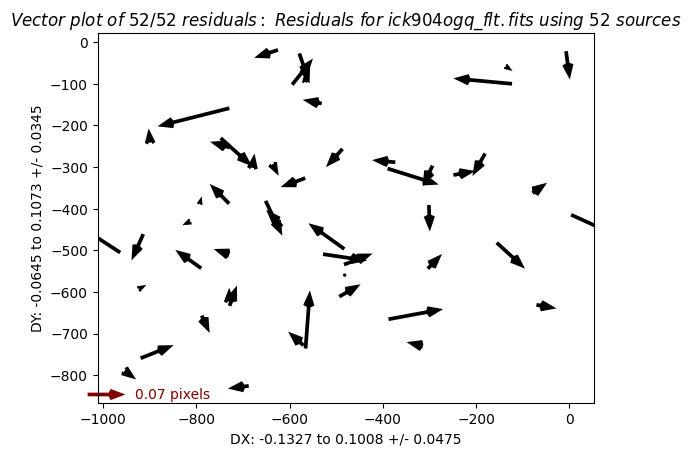

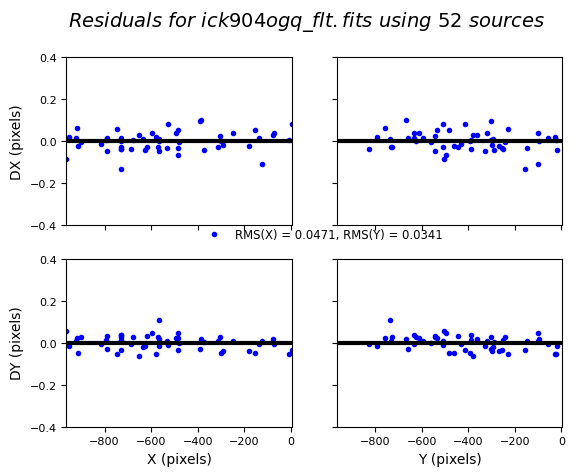

In [13]:
refcat = 'gaia_pm.cat'   # Choose the Gaia catalog with proper motion data
cw = 2.5                 # Set to two times the FWHM of the PSF.
wcsname = 'IR_FLT'       # Specify the WCS name for this alignment

ir_flts = sorted(glob.glob('*flt.fits'))

tweakreg.TweakReg(ir_flts,                                             
                  updatehdr=False,                                  # DO NOT UPDATE the header yet
                  imagefindcfg={'threshold': 150., 'conv_width': cw},  # Detection parameters
                  refcat=refcat,                                    # User supplied catalog (Gaia)
                  interactive=False, see2dplot=False,
                  shiftfile=True,                                   # Save  shift file 
                  outshifts='shift160_flt.txt',                     # name of the shift file
                  wcsname=wcsname,                                  # Give our WCS a unique name
                  reusename=True,
                  searchrad=0.25,
                  sigma=3,
                  ylimit=0.4,
                  fitgeometry='rscale')                             # Fit geometry (shift, rotation, scale)
clear_output()

In [14]:
# If the alignment is unsuccessful, stop the notebook
with open('shift160_flt.txt', 'r') as shift:
    for line_number, line in enumerate(shift, start=1):
        if "nan" in line:
            raise ValueError('nan found in line {} in shift file'.format(line_number))
        else:
            continue

## 6.2 Inspect the shift file to verify the pointing residuals <a id="ir_shift"></a>
`TweakReg` finds stars in each image, matches with the Gaia DR3 reference catalog, and computes residual shifts between exposures. <br> These offsets (given in pixels at the native IR scale=0.1283”/pixel) are recorded in an output “shift file” which is shown below. <br> The computed offsets reflect updates to the header WCS  required to correct for small alignment errors.

In [15]:
shift_table = Table.read('shift160_flt.txt',
                         format='ascii.no_header', 
                         names=['file', 'dx', 'dy', 'rot', 'scale', 'xrms', 'yrms'])

formats = ['.2f', '.2f', '.3f', '.5f', '.2f', '.2f']
for i, col in enumerate(shift_table.colnames[1:]):
    shift_table[col].format = formats[i]
shift_table

<Table length=8>
       file           dx      dy     rot    scale    xrms    yrms 
      str18        float64 float64 float64 float64 float64 float64
------------------ ------- ------- ------- ------- ------- -------
ick901hzq_flt.fits    0.02    0.01 359.997 1.00000    0.05    0.05
ick901i7q_flt.fits   -0.01    0.02   0.001 1.00003    0.05    0.05
ick902n9q_flt.fits   -0.01   -0.00   0.001 1.00001    0.05    0.04
ick902neq_flt.fits    0.01   -0.01   0.000 1.00002    0.05    0.04
ick903n4q_flt.fits   -0.02   -0.00 359.998 1.00001    0.06    0.03
ick903ncq_flt.fits   -0.00   -0.00 359.999 1.00000    0.07    0.04
ick904obq_flt.fits   -0.00    0.01 360.000 0.99999    0.04    0.03
ick904ogq_flt.fits   -0.00   -0.00   0.000 0.99998    0.05    0.03

In [16]:
# Print the Number of Gaia Matches per image from the TweakReg output
match_files = sorted(glob.glob('*_flt_catalog_fit.match'))
for f in match_files:
    input = ascii.read(f)
    print('Number of matches for', f, '= ', len(input))

Number of matches for ick901hzq_flt_catalog_fit.match =  107
Number of matches for ick901i7q_flt_catalog_fit.match =  106
Number of matches for ick902n9q_flt_catalog_fit.match =  104
Number of matches for ick902neq_flt_catalog_fit.match =  107
Number of matches for ick903n4q_flt_catalog_fit.match =  51
Number of matches for ick903ncq_flt_catalog_fit.match =  49
Number of matches for ick904obq_flt_catalog_fit.match =  65
Number of matches for ick904ogq_flt_catalog_fit.match =  52


Compare the RMS and number of Matches from `TweakReg` with the MAST alignment results. <br>

In [17]:
mast_ir_wcs

<Table length=8>
     filename      DETECTOR ... RMS_RApix RMS_DECpix
      str18          str2   ...  float64   float64  
------------------ -------- ... --------- ----------
ick901hzq_flt.fits       IR ...       0.1        0.1
ick901i7q_flt.fits       IR ...       0.1        0.1
ick902n9q_flt.fits       IR ...      0.07       0.07
ick902neq_flt.fits       IR ...      0.07       0.07
ick903n4q_flt.fits       IR ...      0.07       0.07
ick903ncq_flt.fits       IR ...      0.07       0.07
ick904obq_flt.fits       IR ...      0.05       0.06
ick904ogq_flt.fits       IR ...      0.05       0.06

Note that while similar numbers of stars were matched during MAST processing and in our custom alignment, the fit RMS is ~2x lower. Before updating the WCS solutions, we inspect the quality of the fitting in the next section.

## 6.3 Inspect the IR fits <a id="inspect_ir"></a>

To verify that `TweakReg` obtained a good fit between matched source catalogs, it is useful to inspect the results before updating the image header WCS. Below sources matched with Gaia are overplotted on the first exposures from Visits 01 and 02. It can be useful to check that `TweakReg` locked onto stars and not hot pixels or other detector artifacts before proceeding. 

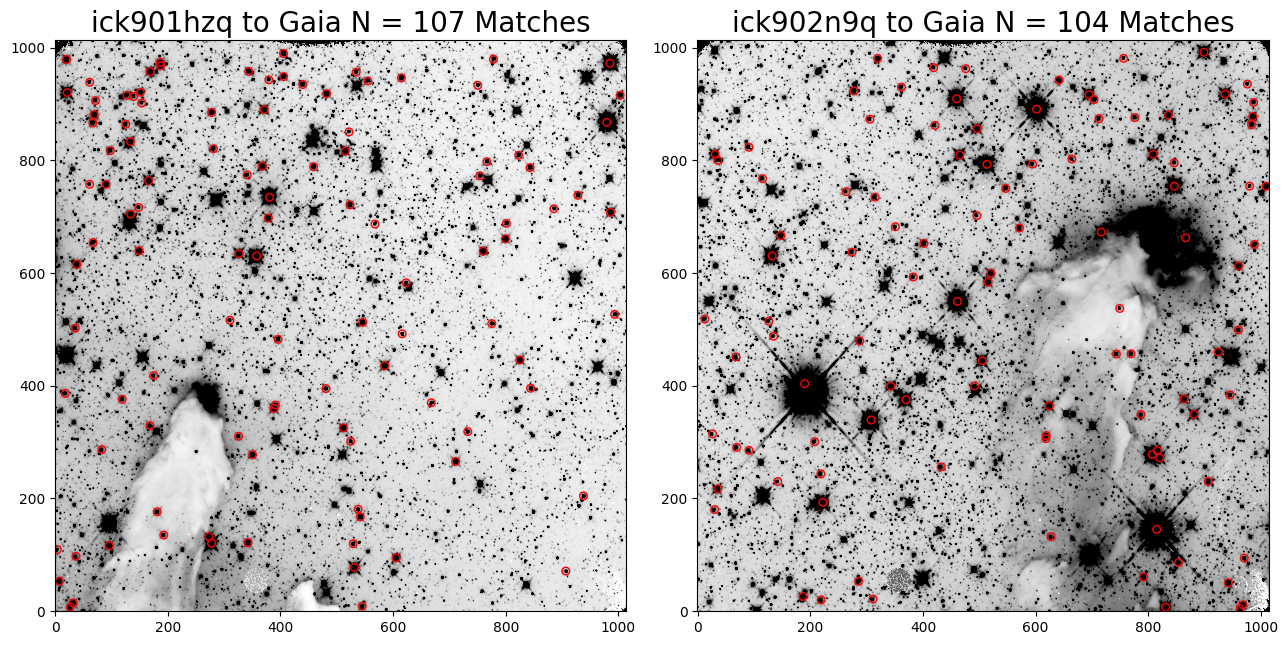

In [18]:
rootname1a = 'ick901hzq'
rootname2a = 'ick902n9q'
rootname3a = 'ick903n4q'
rootname4a = 'ick904ogq'

panel1_rootname = rootname1a   # Visit 01               #This cell requires two visits as input (uncommented)
panel2_rootname = rootname2a   # Visit 02
# panel1_rootname = rootname3a   # Visit 03
# panel2_rootname = rootname4a   # Visit 04

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(13, 10))
data_a = fits.open(panel1_rootname+'_flt.fits')['SCI', 1].data
data_b = fits.open(panel2_rootname+'_flt.fits')['SCI', 1].data
zscale = ZScaleInterval()
z1, z2 = zscale.get_limits(data_a)
ax1.imshow(data_a, cmap='Greys', origin='lower', vmin=z1, vmax=z2)
ax2.imshow(data_b, cmap='Greys', origin='lower', vmin=z1, vmax=z2)

match_tab_a = ascii.read(panel1_rootname+'_flt_catalog_fit.match')
match_tab_b = ascii.read(panel2_rootname+'_flt_catalog_fit.match') # load match file in astropy table
x_coord_a, y_coord_a = match_tab_a['col11'], match_tab_a['col12']
x_coord_b, y_coord_b = match_tab_b['col11'], match_tab_b['col12']

ax1.scatter(x_coord_a, y_coord_a, s=30, edgecolor='r', facecolor='None')
ax2.scatter(x_coord_b, y_coord_b, s=30, edgecolor='r', facecolor='None')

ax1.set_title(f'{panel1_rootname} to Gaia N = {len(match_tab_a)} Matches', fontsize=20)
ax2.set_title(f'{panel2_rootname} to Gaia N = {len(match_tab_b)} Matches', fontsize=20)
fig.tight_layout()

Next, the 4-panel fit residual plots: dx, dy vs X and Y are inspected to verify that the residuals cluster around zero. 

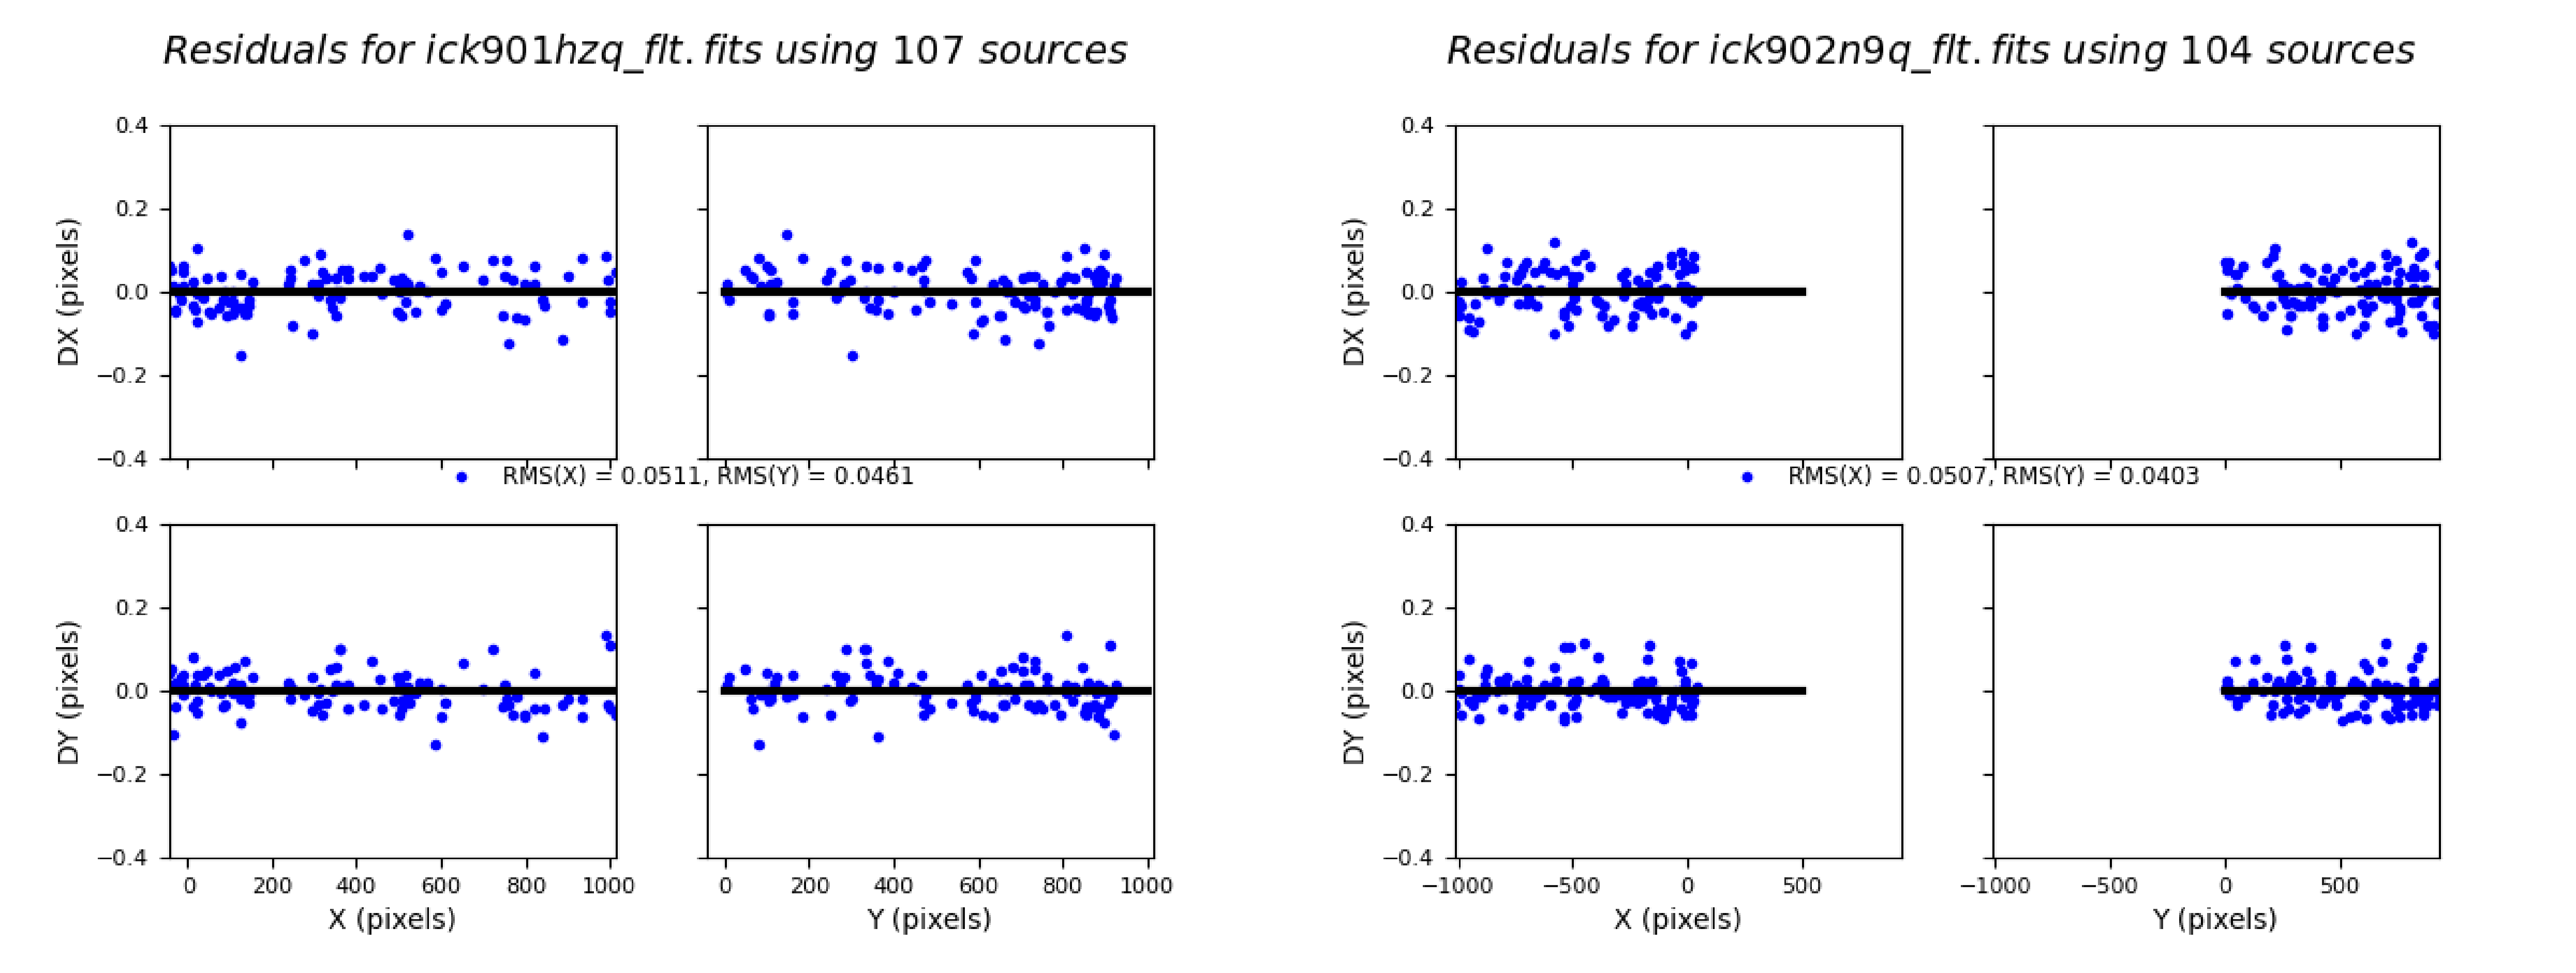

In [19]:
# read images
panel1_png = mpimg.imread(f'residuals_{panel1_rootname}_flt.png')
panel2_png = mpimg.imread(f'residuals_{panel2_rootname}_flt.png')
# display images
fig, axs = plt.subplots(1, 2, figsize=(25, 25), dpi=200)
axs[0].imshow(panel1_png)
axs[1].imshow(panel2_png)
axs[0].axis('off')
axs[1].axis('off')
fig.tight_layout()

We repeat the following for Visits 03 and 04. 

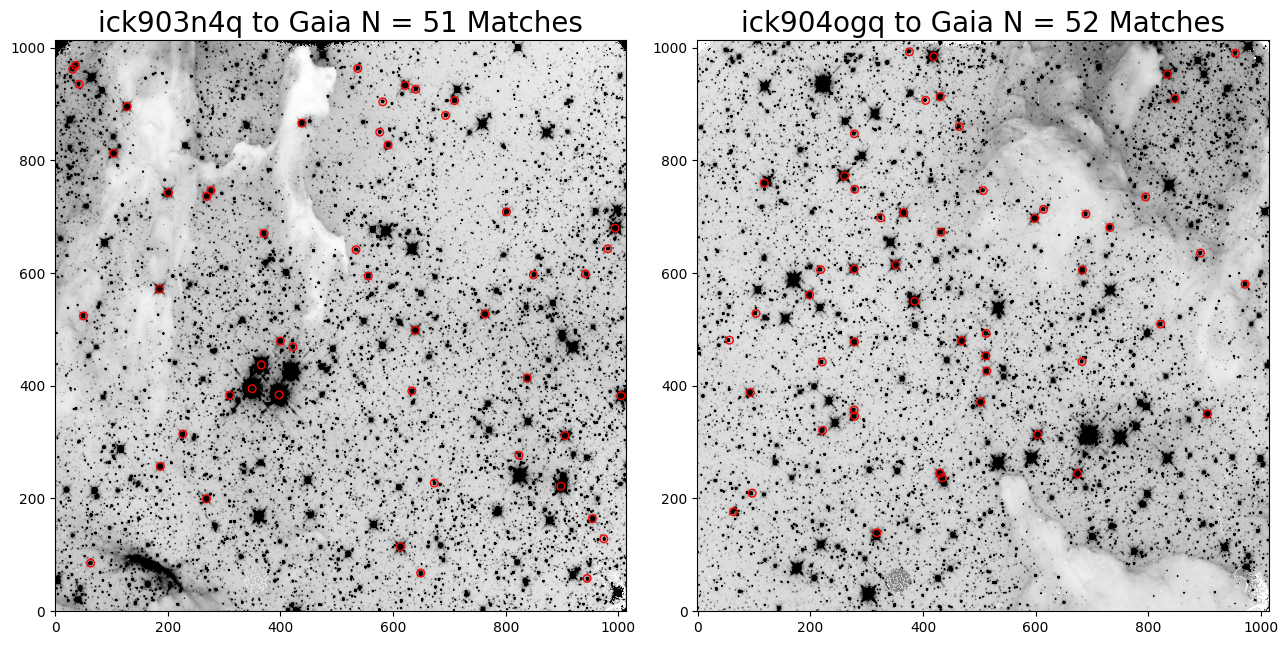

In [20]:
# panel1_rootname =rootname1a   # Visit 01          #This cell requires two visits as input (uncommented)
# panel2_rootname =rootname2a   # Visit 02
panel1_rootname = rootname3a   # Visit 03
panel2_rootname = rootname4a   # Visit 04

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(13, 10))
data_a = fits.open(panel1_rootname+'_flt.fits')['SCI', 1].data
data_b = fits.open(panel2_rootname+'_flt.fits')['SCI', 1].data
zscale = ZScaleInterval()
z1, z2 = zscale.get_limits(data_a)
ax1.imshow(data_a, cmap='Greys', origin='lower', vmin=z1, vmax=z2)
ax2.imshow(data_b, cmap='Greys', origin='lower', vmin=z1, vmax=z2)

match_tab_a = ascii.read(panel1_rootname+'_flt_catalog_fit.match')
match_tab_b = ascii.read(panel2_rootname+'_flt_catalog_fit.match') # load match file in astropy table
x_coord_a, y_coord_a = match_tab_a['col11'], match_tab_a['col12']
x_coord_b, y_coord_b = match_tab_b['col11'], match_tab_b['col12']

ax1.scatter(x_coord_a, y_coord_a, s=30, edgecolor='r', facecolor='None')
ax2.scatter(x_coord_b, y_coord_b, s=30, edgecolor='r', facecolor='None')

ax1.set_title(f'{panel1_rootname} to Gaia N = {len(match_tab_a)} Matches', fontsize=20)
ax2.set_title(f'{panel2_rootname} to Gaia N = {len(match_tab_b)} Matches', fontsize=20)
fig.tight_layout()

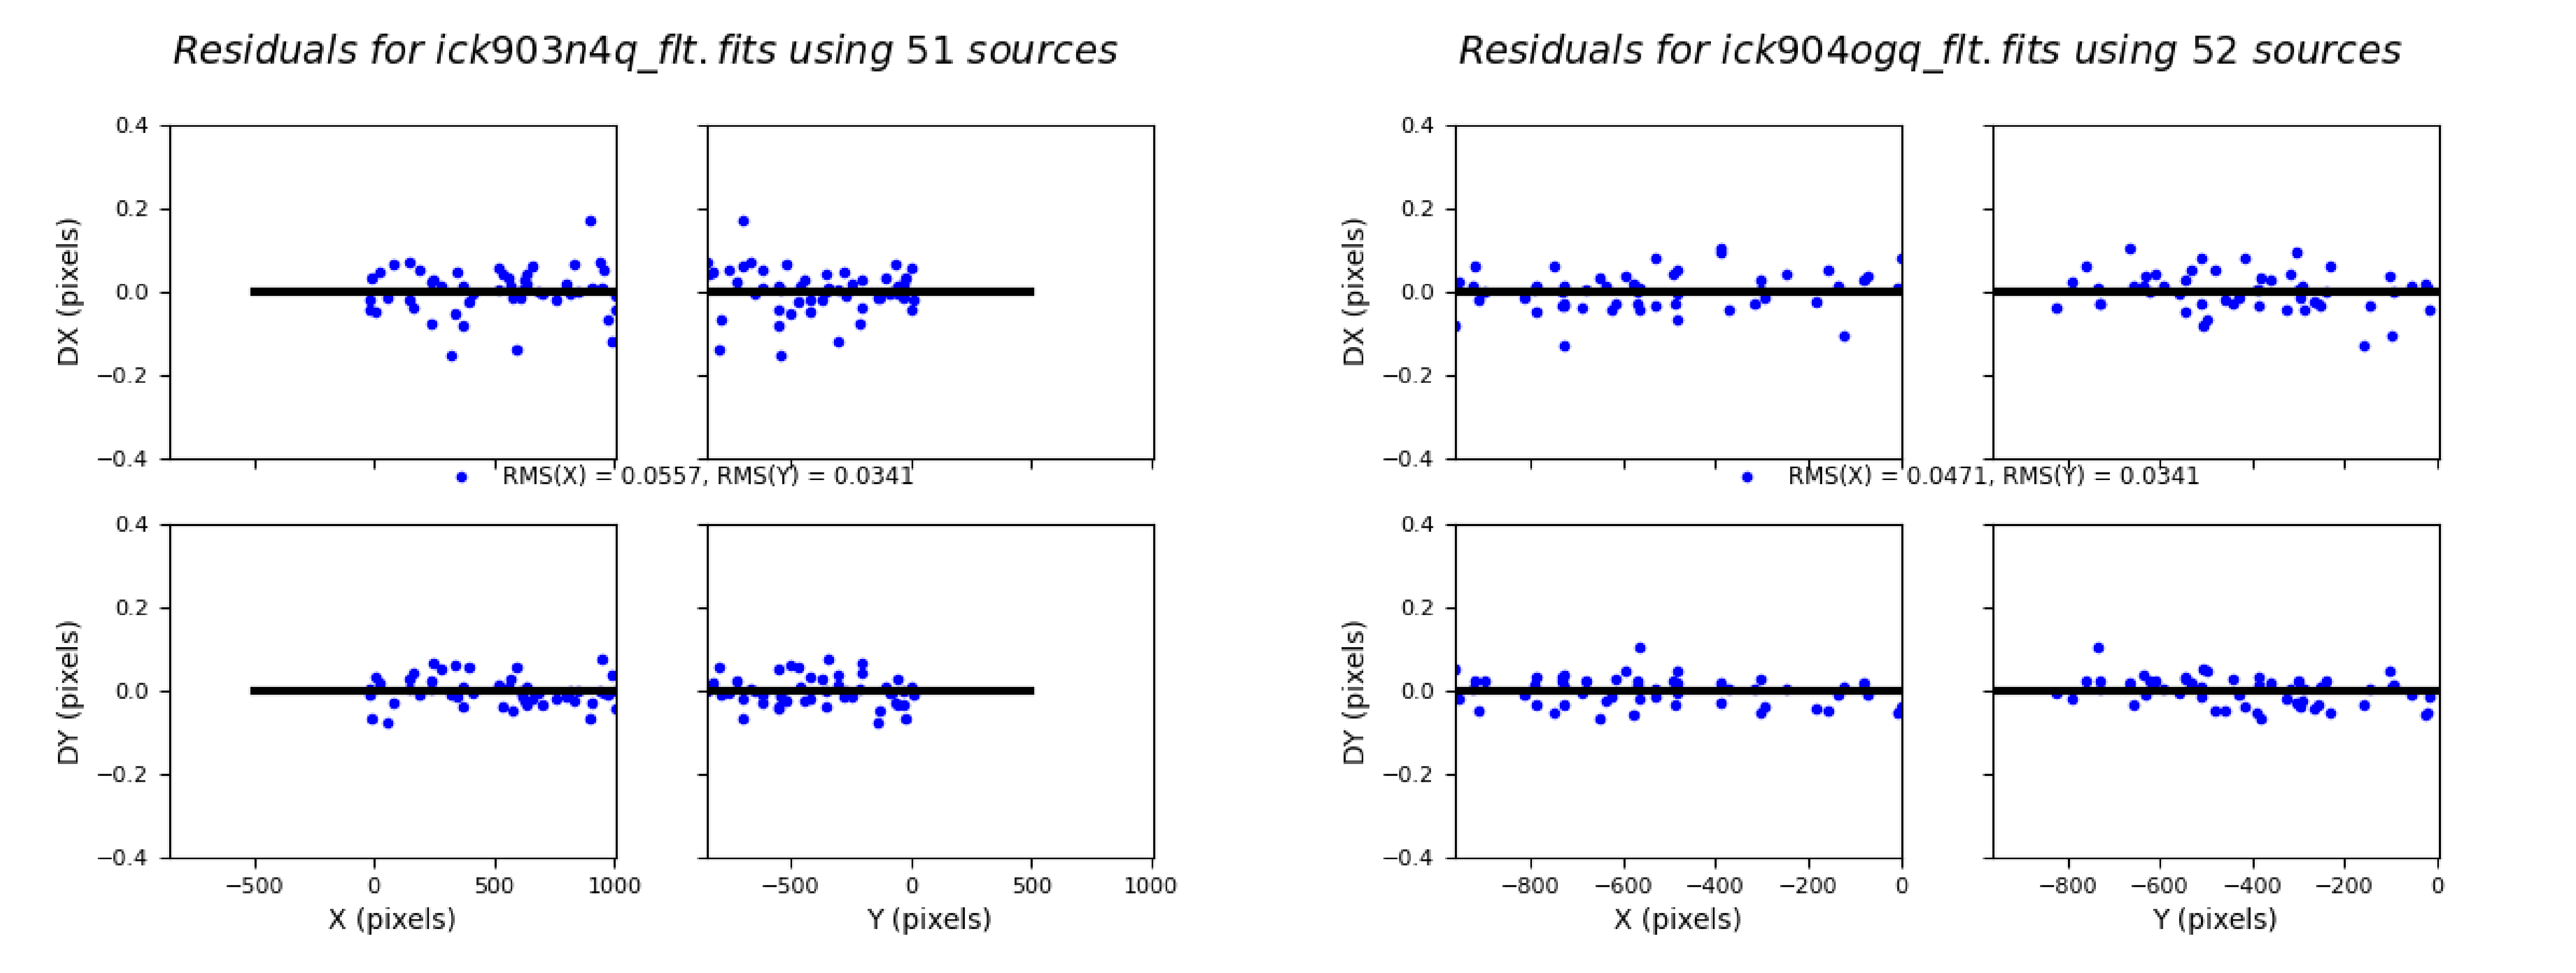

In [21]:
# read images
panel1_png = mpimg.imread(f'residuals_{panel1_rootname}_flt.png')
panel2_png = mpimg.imread(f'residuals_{panel2_rootname}_flt.png')
# display images
fig, axs = plt.subplots(1, 2, figsize=(25, 25), dpi=200)
axs[0].imshow(panel1_png)
axs[1].imshow(panel2_png)
axs[0].axis('off')
axs[1].axis('off')
fig.tight_layout()

The dx,dy residuals for all IR exposures are all clustered around dx,dy=0 and have an RMS less than 0.1 pixels, indicating a good fit. If the alignment needs to be fine-tuned, changing the parameters `threshold`, `sigma`, and `searchrad` may help TweakReg to lock onto an accurate solution. 

Since the fit looks good, the RMS is better than the MAST solution, and there appears to be a small residual rotation in the shift file, we rerun TweakReg but now with `updatehdr=True` to update the header WCS with the new Gaia fit. Here we set a unique name for the WCS solution to be `IR_FLT_GAIA`.

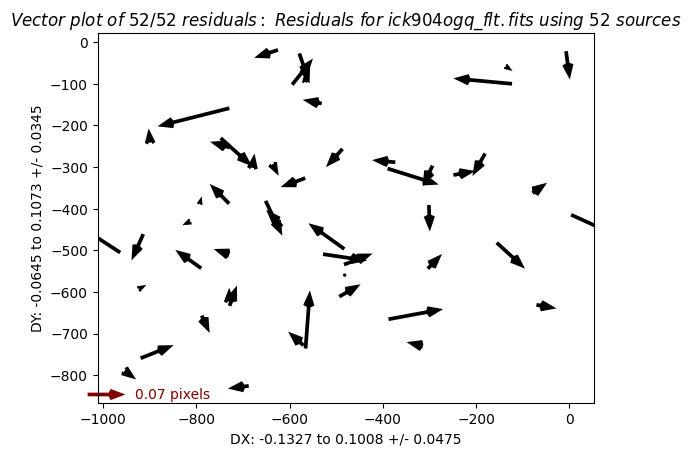

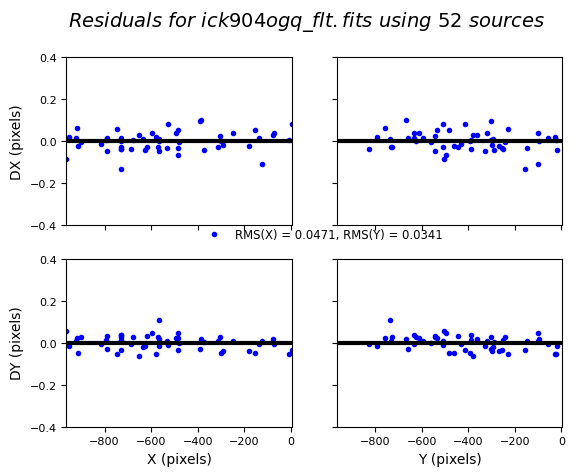

In [22]:
refcat = 'gaia_pm.cat'   # Choose the Gaia catalog with proper motion data
cw = 2.5                 # Set to two times the FWHM of the PSF.
wcsname = 'IR_FLT_GAIA'       # Specify the WCS name for this alignment

ir_flts = sorted(glob.glob('*flt.fits'))

tweakreg.TweakReg(ir_flts,                                             
                  updatehdr=True,                                      # Update header NOW ******
                  imagefindcfg={'threshold': 150., 'conv_width': cw},     # Detection parameters
                  refcat=refcat,                                       # User supplied catalog (Gaia)
                  interactive=False, see2dplot=False, shiftfile=False,                                   
                  wcsname=wcsname,                                     # Give our WCS a unique name
                  reusename=True,
                  searchrad=0.25,
                  sigma=3,
                  ylimit=0.4,
                  fitgeometry='rscale')                             # Fit geometry (shift, rotation, scale)
clear_output()

## 7. Mosaicking Features in AstroDrizzle <a id="mosaic_feat"></a>

`AstroDrizzle` now makes it easier for users to match the sky background when tiling together large mosaics. In prior versions of the software, the sky method `localmin` was computed using clipped statistics in each image separately. The sky background was measured for each chip and the lowest sky value (in electrons/arcsec^2) among all of the chips was adopted. For observations of sparse fields, this approach generally works well. However, when large extended objects fill the detector, there is no true 'blank sky' and the background value will be an overestimate. Additionally, when extended targets are observed as mosaics (e.g. with large dithers), the 'scene' can change significantly between exposures and bias the background estimate.

An error in determining the sky background may in turn impact the cosmic-ray rejection, and if severe enough, the resulting photometry. Additionally, by not properly matching the sky background before combining frames, correlated noise will be added to the final drizzled products when differences in the background levels are significant. Until now, the recommended workaround has been for users to give `AstroDrizzle` an ASCII file containing user-defined background values via the `skyfile` parameter.

AstroDrizzle now features several options for computing the sky. One of these, `skymethod='match`, is useful for “equalizing” the sky background across large mosaics. This method computes differences in sky values using only pixels in common between images. The sky values will then be set relative to the value computed for the input frame with the lowest sky value for which the MDRIZSKY keyword will be set to 0. In this way, the sky background is not removed, but instead equalized before the data are combined. For more details on the sky matching functions used by `AstroDrizzle`, see the [readthedocs](https://drizzlepac.readthedocs.io/en/latest/drizzlepac_api/sky.html) and [skypac](https://stsci-skypac.readthedocs.io/en/latest/skymatch.html) online documentation.

## 7.1 Drizzle the IR/F160W Mosaic <a id="ir_driz"></a>

Finally, `AstroDrizzle` can be used to combine the full set of F160W frames. In this case the final orientation has been set to -35 degrees so that the pillars will be oriented vertically. Note that users must first set the parameter `final_wcs='True'` in order to turn on parameters in AstroDrizzle’s step 7a: `Custom WCS for Final Output`. For these observations, the IR scale (0.08”/pixel) is chosen to be exactly twice that for the UVIS mosaics (0.04”/pixel) by setting `final_scale=0.08`, and the drizzled images have been oversized slightly to match the sky area on the sky covered by the UVIS. The sky background may be equalized across mosaic tiles by setting the parameter `skymethod='match'`.
   
The parameter `final_bits` defines which DQ flags in the FLT image to treat as good. All other pixels with non-zero DQ values will be assumed to be bad and rejected from the final mosaic. For IR data, these two parameters are typically set to 64+512 in the pipeline, corresponding to warm pixels and IR blobs. This program included a blob dither, however, and so the 512 flag may be removed from the list of good DQ values such that these pixels will be replaced with non-flagged pixels from the accompanying dithered pair. 

For IR data, cosmic-rays have already rejected via the 'up-the-ramp' fitting by calwf3, so Steps 3, 4, 5, 6 in AstroDrizzle have been turned off when combining the FLT exposures.  See [readthedocs](https://drizzlepac.readthedocs.io/en/latest/drizzlepac_api.html) for more information about the various input parameters to AstroDrizzle.

In [23]:
adriz(ir_flts, output='f160w',
      preserve=False, clean=True, build=False, context=False,
      driz_separate=False, median=False, blot=False, driz_cr=False,  # Turn off cr-rejection
      skymethod='match', 
      final_bits='16',                                               # Only DQ=16 are good (stable hot pixels)
      final_wcs=True, final_scale=0.08, final_rot=-35,
      final_ra=274.721587, final_dec=-13.841549,
      final_outnx=4000, final_outny=4500)

clear_output()

## 7.2 Display the combined DRZ science and weight images <a id="ir_drz"></a>

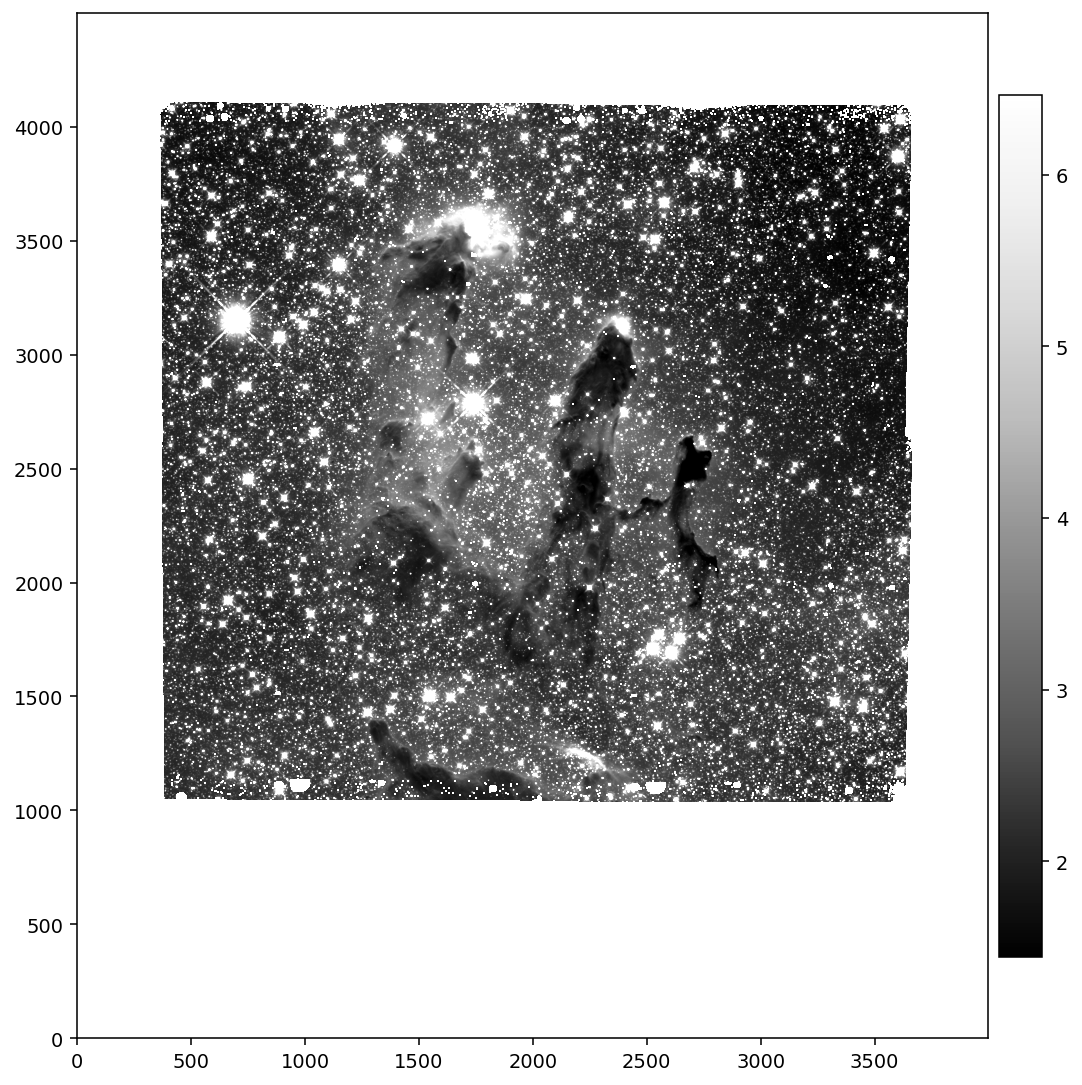

In [24]:
sci = fits.getdata('f160w_drz_sci.fits')
fig = plt.figure(figsize=(10, 10), dpi=140)
z1, z2 = zscale.get_limits(sci)
plt.imshow(sci, vmin=z1, vmax=z2, cmap='Greys_r', origin='lower')
plt.colorbar(shrink=0.8, pad=0.01)

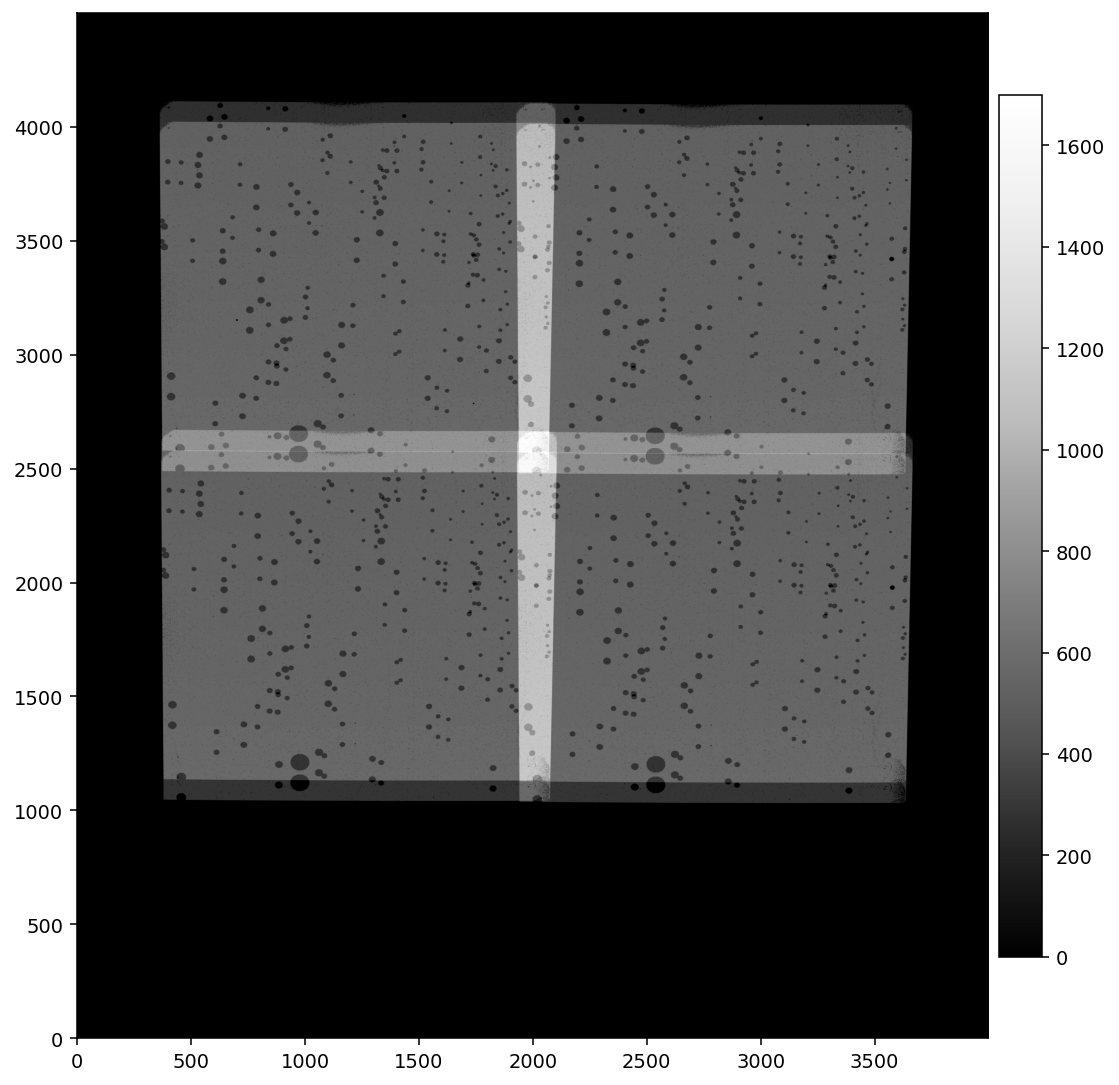

In [25]:
wht = fits.getdata('f160w_drz_wht.fits')
fig = plt.figure(figsize=(10, 10), dpi=140)
plt.imshow(wht, vmin=0, vmax=1700, cmap='Greys_r', origin='lower')
plt.colorbar(shrink=0.8, pad=0.01)

## 8. Align the UVIS FLC frames to the IR mosaic <a id="uvis_align"></a>

The F160W drizzled mosaic defines the reference frame for aligning the UVIS filters. In [ISR 2015-09](http://www.stsci.edu/hst/wfc3/documents/ISRs/WFC3-2015-09.pdf), the UVIS visit-level DRC frames were aligned directly to the IR reference image, and this approach was chosen because the long UVIS exposures contain numerous cosmic-rays and relatively few point sources. The DrizzlePac task `TweakBack` was then used to propagate the updated WCS from the drizzled image header back to the individual FLC input frames making up each association prior to drizzling.

In this notebook, we instead align the UVIS FLC frames directly to the Gaia catalog, making use of a parameter in `TweakReg` which allows for specific flags in the DQ array of the FLC frames to be used or ignored. The `imagefindpars` parameter `dqbits` may be prepended with tilda to the string value to indicate which DQ flags to consider as "bad" pixels. For example, when deriving source catalogs, `Tweakreg` will ignore any pixels flagged as cosmic-ray flags in the MAST visit-level drizzled data products when `dqbits` is set to ~4096. This dramatically cuts down the number of false detections due to cosmic rays in the input FLC science arrays. More details on `imagefindpars` options may be found on the following [webpage](https://drizzlepac.readthedocs.io/en/latest/user_reprocessing/imagefindpars.html). 

In this example, the `threshold` value was manually adjusted to get ~100 matches per UVIS exposure. Note that setting the `threshold` to a very low value does not necessarily translate to a better solution, since all sources are weighted equally when computing fits to match catalogs. This is especially relevant for UVIS data where CTE tails can shift the centroid position slightly along the readout direction for faint sources and potentially bias the fit.

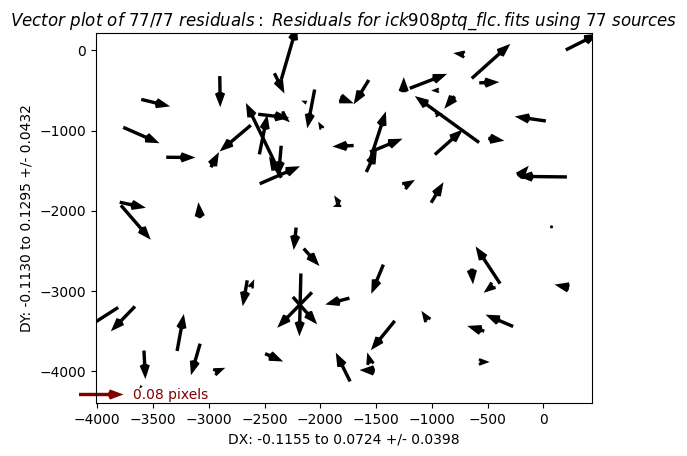

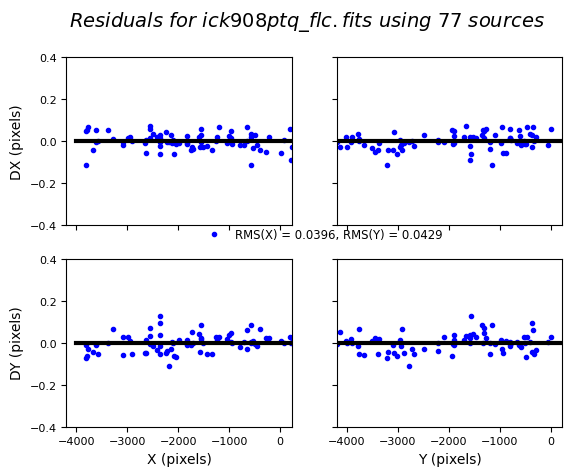

In [26]:
refcat = 'gaia_pm.cat'   # Choose the Gaia catalog with proper motion data
cw = 3.5                 # Set to two times the FWHM of the PSF. (3.5 pixels for UVIS, 2.5 pixels for IR)
wcsname = 'UVIS_FLT'       # Specify the WCS name for this alignment

uvis_flcs = sorted(glob.glob('*flc.fits'))

tweakreg.TweakReg(uvis_flcs,                                             
                  updatehdr=False,                                  # DO NOT UPDATE the header yet
                  refcat=refcat,                                    
                  imagefindcfg={'threshold': 40., 'conv_width': cw, 'dqbits': "~4096"},  
                  interactive=False, see2dplot=False,
                  shiftfile=True,  
                  outshifts='shift657_flc.txt',                     
                  wcsname=wcsname,                                  # Give our WCS a unique name
                  reusename=True,
                  searchrad=0.3,
                  sigma=3,
                  ylimit=0.4,
                  fitgeometry='rscale')                             # Fit geometry (shift, rotation, scale)
clear_output()                 

In [27]:
# If the alignment is unsuccessful, stop the notebook

with open('shift657_flc.txt', 'r') as shift:
    for line_number, line in enumerate(shift, start=1):
        if "nan" in line:
            raise ValueError('nan found in line {} in shift file'.format(line_number))
        else:
            continue

## 8.1 Inspect the shift file to verify the pointing residuals <a id="inspect_resid"></a>

Because each visit was acquired using a unique pair of Guide Stars, the three FLC exposures making up each visit should have roughly similar residual corrections to the WCS, which can be seen in the table below. Since the residuals in the shift file are close to zero and the rms values are <0.1 pixel, we can be confident that the fitting was successful.

In [28]:
shift_table = Table.read('shift657_flc.txt', format='ascii.no_header', names=['file', 'dx', 'dy', 'rot', 'scale', 'xrms', 'yrms'])

formats = ['.2f', '.2f', '.3f', '.5f', '.2f', '.2f']
for i, col in enumerate(shift_table.colnames[1:]):
    shift_table[col].format = formats[i]
shift_table

<Table length=12>
       file           dx      dy     rot    scale    xrms    yrms 
      str18        float64 float64 float64 float64 float64 float64
------------------ ------- ------- ------- ------- ------- -------
ick905k5q_flc.fits   -0.01    0.02   0.000 1.00000    0.06    0.05
ick905keq_flc.fits    0.01    0.04   0.000 0.99999    0.05    0.04
ick905knq_flc.fits    0.04    0.02 360.000 0.99999    0.05    0.04
ick906kwq_flc.fits    0.04    0.08 359.999 1.00000    0.06    0.06
ick906l5q_flc.fits    0.03    0.04 360.000 1.00000    0.06    0.05
ick906leq_flc.fits    0.02    0.01 360.000 1.00000    0.05    0.05
ick907nkq_flc.fits   -0.00    0.05 359.999 1.00001    0.06    0.04
ick907o1q_flc.fits   -0.02   -0.06 359.999 1.00000    0.05    0.05
ick907ouq_flc.fits    0.01    0.06   0.000 1.00000    0.05    0.05
ick908pbq_flc.fits    0.00    0.02   0.000 1.00001    0.03    0.03
ick908pkq_flc.fits    0.01    0.02   0.000 1.00001    0.04    0.04
ick908ptq_flc.fits    0.02    0.01   0.000 1.00000    0.04    0.04

In [29]:
# Print the Number of Gaia Matches per image from the TweakReg output
match_files = sorted(glob.glob('*_flc_catalog_fit.match'))
for f in match_files:
    input = ascii.read(f)
    print('Number of matches for', f, '= ', len(input))

Number of matches for ick905k5q_flc_catalog_fit.match =  136
Number of matches for ick905keq_flc_catalog_fit.match =  132
Number of matches for ick905knq_flc_catalog_fit.match =  119
Number of matches for ick906kwq_flc_catalog_fit.match =  144
Number of matches for ick906l5q_flc_catalog_fit.match =  136
Number of matches for ick906leq_flc_catalog_fit.match =  135
Number of matches for ick907nkq_flc_catalog_fit.match =  71
Number of matches for ick907o1q_flc_catalog_fit.match =  76
Number of matches for ick907ouq_flc_catalog_fit.match =  75
Number of matches for ick908pbq_flc_catalog_fit.match =  78
Number of matches for ick908pkq_flc_catalog_fit.match =  80
Number of matches for ick908ptq_flc_catalog_fit.match =  77


Compare the RMS and number of Matches from `TweakReg` with the MAST alignment results. 

In [30]:
mast_uvis_wcs

<Table length=12>
     filename      DETECTOR ... RMS_RApix RMS_DECpix
      str18          str4   ...  float64   float64  
------------------ -------- ... --------- ----------
ick905k5q_flc.fits     UVIS ...      0.11        0.1
ick905keq_flc.fits     UVIS ...      0.11        0.1
ick905knq_flc.fits     UVIS ...      0.11        0.1
ick906kwq_flc.fits     UVIS ...      0.11        0.1
ick906l5q_flc.fits     UVIS ...      0.11        0.1
ick906leq_flc.fits     UVIS ...      0.11        0.1
ick907nkq_flc.fits     UVIS ...      0.06       0.09
ick907o1q_flc.fits     UVIS ...      0.06       0.09
ick907ouq_flc.fits     UVIS ...      0.06       0.09
ick908pbq_flc.fits     UVIS ...      0.13       0.11
ick908pkq_flc.fits     UVIS ...      0.13       0.11
ick908ptq_flc.fits     UVIS ...      0.13       0.11

Note that there are similar numbers of stars matched during MAST processing and in our custom alignment, with no significant shift rotation or scale resiuals in the shift file.  To verify this, we inspect the quality of the fitting in the next section.

## 8.2 Inspect the UVIS fits  <a id="uvis_inspect"></a>

Here, we overplot matched sources on the FLC frame, pasting the two chips together. In this example, we show only the first exposure in Visit 05, but additional visits may be inspected by uncommenting the lines below starting with `rootname=`. 

Text(0.5, 1.0, 'ick905k5q to Gaia N = 136 Matches')

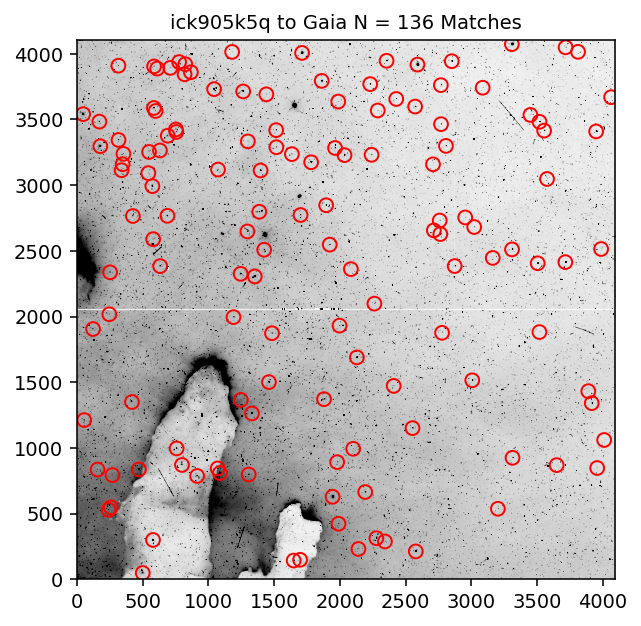

In [31]:
rootname = 'ick905k5q'     # Visit 05a
# rootname = 'ick906kwq'   # Visit 06a
# rootname = 'ick907nkq'   # Visit 07a
# rootname = 'ick908pbq'   # Visit 08a  

plt.figure(figsize=(5, 5), dpi=140)
chip1_data = fits.open(rootname+'_flc.fits')['SCI', 2].data
chip2_data = fits.open(rootname+'_flc.fits')['SCI', 1].data
fullsci = np.concatenate([chip2_data, chip1_data])
z1, z2 = zscale.get_limits(fullsci)
plt.imshow(fullsci, cmap='Greys', origin='lower', vmin=z1, vmax=z2)

match_tab = ascii.read(rootname+'_flc_catalog_fit.match')  # load match file in astropy table
match_tab_chip1 = match_tab[match_tab['col15'] == 2]   # filter table for sources on chip 1 (on ext 4)
match_tab_chip2 = match_tab[match_tab['col15'] == 1]   # filter table for sources on chip 2 (on ext 1)
x_cord1, y_cord1 = match_tab_chip1['col11'], match_tab_chip1['col12']
x_cord2, y_cord2 = match_tab_chip2['col11'], match_tab_chip2['col12']

plt.scatter(x_cord1, y_cord1+2051, s=50, edgecolor='r', facecolor='None', label='Matched Sources')
plt.scatter(x_cord2, y_cord2, s=50, edgecolor='r', facecolor='None')
plt.title(f'{rootname} to Gaia N = {len(match_tab)} Matches', fontsize=10)

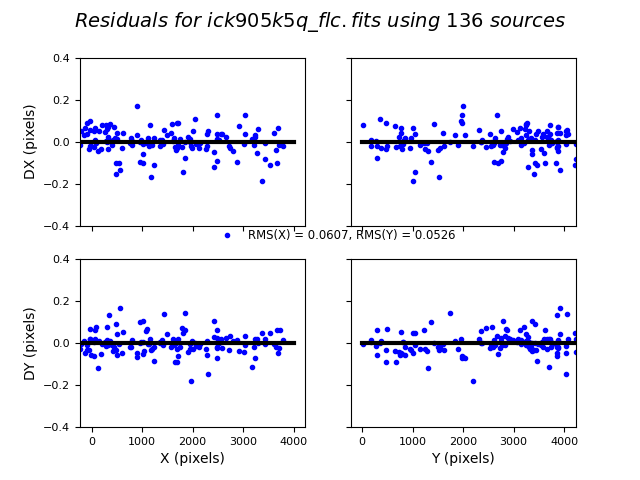

In [32]:
# inspect residual PNG 
Image(filename=f'residuals_{rootname}_flc.png', width=500, height=300)

Below is the `TweakReg` call to update the header WCS. However since the shift file shows that the MAST alignment is good, we will not need to run this cell.

In [33]:
# tweakreg.TweakReg(uvis_flcs,                                             
#                   updatehdr=True,                                  # Update the header
#                   refcat=refcat,                                    
#                   interactive=False, see2dplot=False, shiftfile=False,  
#                   imagefindcfg={'threshold':40.,'conv_width':cw,'dqbits': "~4096"},  
#                   wcsname=wcsname,                                  # Give our WCS a unique name
#                   reusename=True,
#                   searchrad=0.3,
#                   sigma=3,
#                   ylimit=0.4,
#                   fitgeometry='rscale')                             # Fit geometry (shift, rotation, scale)
#  clear_output()           

## 9. Drizzling the F657N mosaic <a id="mosaic_657"></a>

Now that we have confirmed the alignment of the 12 FLC frames, these may be drizzled to a mosaic exactly half the scale (0.04"/pixel) of the original IR mosaic (0.08"/pixel). The same output WCS paramters: `final_rot`,`final_ra`, and `final_dec` values are used, but the `final_outnx` and `final_outny` are now twice the size of the IR mosaic at 8000x9000 pixels. 

To save time for this notebook, the visit-level cosmic-ray flags for the individual UVIS tiles are assumed to be adequate, Steps 3, 4, 5, 6 are turned off, and the parameter `resetbits` is set to '0' to avoid wiping out the 4096 flags in the FLC data quality arrays.

To improve processing speed, the sky background levels have been provided in advance and fed to `AstroDrizzle` via the `skyfile` parameter which reads in the input text file `align_mosaics_uvis_skyfile.txt`. Users would typically set `skymethod='match'` to compute the sky background levels, and this populates the image header keyword MDRIZSKY with the sky values in the imheader header of the FLC FITS files. 

To further improve cosmic-ray rejection in the chip gap, `AstroDrizzle` may alternatively be run with all steps turned on as shown in the text below and with `resetbits=4096` to update the DQ flags. 

```
astrodrizzle.AstroDrizzle(input_uvis_images,
                          preserve=False, clean=False, build=False, context=False,
                          output='f657n_improved',
                          resetbits=4096,                              # Wipe out the CR flags
                          skymethod='match',                           # Sky Matching takes a lot of memory
                          combine_type='minmed',
                          final_bits='64,16',
                          final_wcs=True, final_scale=0.04, final_rot=-35,
                          final_ra=274.721587,final_dec=-13.841549,
                          final_outnx=8000, final_outny=9000)
```

<div class="alert alert-block alert-warning" style="color:black" >  Depending on your connection speed, this cell may take a few minutes to execute. </div>

In [34]:
input_uvis_images = sorted(glob.glob('*flc.fits'))

adriz(input_uvis_images,
      preserve=False, clean=False, build=False, context=False,
      output='f657n',
      driz_separate=False, median=False, blot=False, driz_cr=False,   # Turn off CR rejection steps
      resetbits=0,                                                    # Do not wipe out the MAST DQ flags               
      skyfile='align_mosaics_uvis_skyfile.txt',                       # Provide user-defined sky values 
      final_bits='64, 16',
      final_wcs=True, final_scale=0.04, final_rot=-35,                # Set the output WCS
      final_ra=274.721587, final_dec=-13.841549,
      final_outnx=8000, final_outny=9000)

clear_output()

## 9.1 Display the combined DRC science and weight images <a id="uvis_drc"></a>

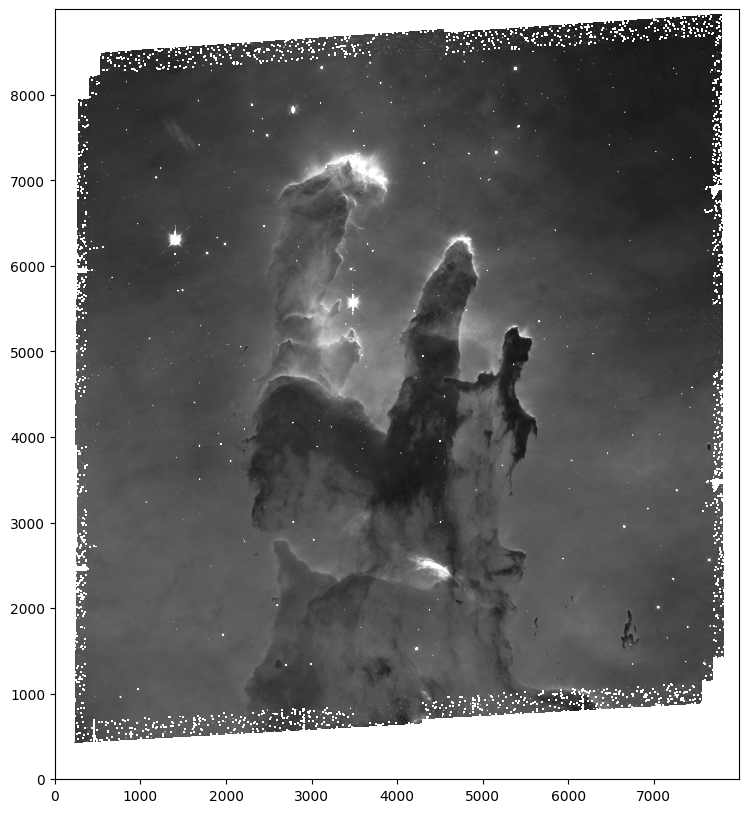

In [35]:
sci = fits.getdata('f657n_drc_sci.fits')
fig = plt.figure(figsize=(10, 10))
plt.imshow(sci, vmin=0, vmax=1, cmap='Greys_r', origin='lower')

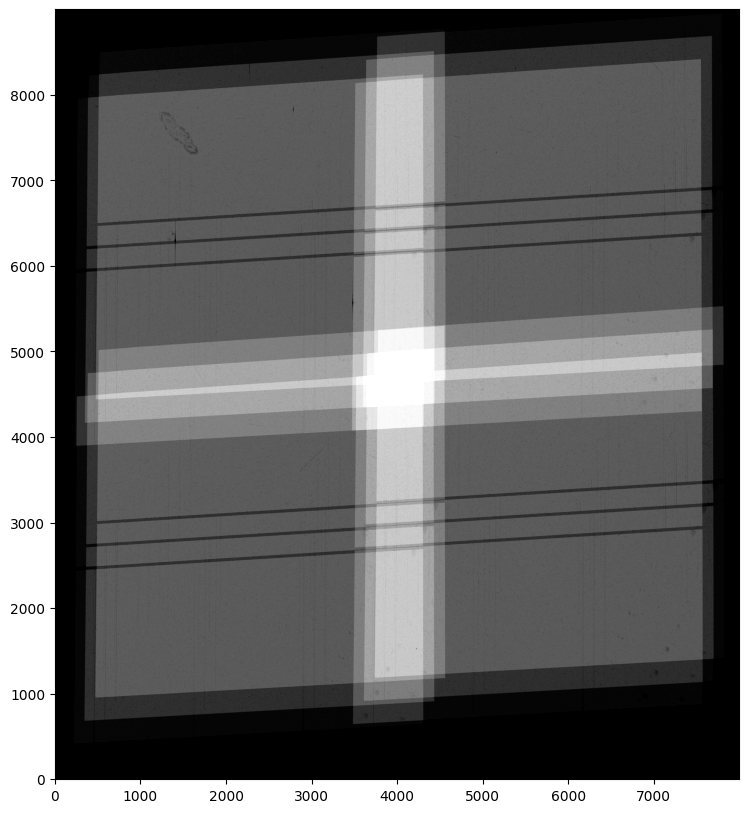

In [36]:
sci = fits.getdata('f657n_drc_wht.fits')
fig = plt.figure(figsize=(10, 10))
plt.imshow(sci, vmin=500, vmax=5000, cmap='Greys_r', origin='lower')

## 10. Conclusions <a id="conclusions"></a>

This notebook provides the methodology for creating UVIS and IR mosaics of M16, as well as recommendations for key parameters. As such, it is relevant for users combining multi-visit observations from any HST imaging program, whether mosaics or single pointings. 

For more detail on aligning to an absolute reference catalog such as GAIA, see the notebook 'aligning_to_catalogs.ipynb'. 

Thank you for walking through this notebook. You should be more familiar with:

- Downloading data with astroquery.
- Examining the active WCS.
- Creating a reference catalog and aligning a dataset to it.
- Checking tweakreg results.
- Drizzling two detectors to the same output 

**Congratulations, you have completed the notebook.**

## Additional Resources <a id="add"></a>

Try to weave resource links into the main content of your tutorial so that they are falling in line with the context of your writing. For resources that do not fit cleanly into your narrative, you may include an additional resources section at the end of your tutorial. Usually a list of links using markdown bullet list plus link format is appropriate.

Below are some additional resources that may be helpful. Please send any questions through the [HST Help Desk](https://stsci.service-now.com/hst).

- [WFC3 Website](https://www.stsci.edu/hst/instrumentation/wfc3)
- [WFC3/UVIS CTE Website](https://www.stsci.edu/hst/instrumentation/wfc3/performance/cte)
- [WFC3 Instrument Handbook](https://hst-docs.stsci.edu/wfc3ihb)
- [WFC3 Data Handbook](https://hst-docs.stsci.edu/wfc3dhb)
    - See Section 3.4.1 for documentation on `wf3cte`, WFC3's CTE correction pipeline
    - See Section 6 for documentation on WFC3/UVIS CTE


## About this Notebook <a id="about"></a>

    Created: 14 Dec 2018;     J. Mack
    Updated: 31 May 2024;     J. Mack & B. Kuhn

**Source:** GitHub [spacetelescope/hst_notebooks](https://github.com/spacetelescope/hst_notebooks)

## Citations <a id="cite"></a>
Provide your reader with guidelines on how to cite open source software and other resources in their own published work.

If you use Python packages such as `astropy`, `astroquery`, `drizzlepac`, `matplotlib`, or `numpy` for published research, please cite the
authors. Follow these links for more information about citing various packages.


* [Citing `astropy`](https://www.astropy.org/acknowledging.html)
* [Citing `astroquery`](https://github.com/astropy/astroquery/blob/main/astroquery/CITATION)
* [Citing `drizzlepac`](https://zenodo.org/records/3743274)
* [Citing `matplotlib`](https://matplotlib.org/stable/users/project/citing.html)
* [Citing `numpy`](https://www.scipy.org/citing.html#numpy)
***

[Top of Page](#top)
<img style="float: right;" src="https://raw.githubusercontent.com/spacetelescope/notebooks/master/assets/stsci_pri_combo_mark_horizonal_white_bkgd.png" alt="Space Telescope Logo" width="200px"/> 